# Clustering - Visualizations
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manim
import numpy as np
import imageio as iio

from clustering__utils import *

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.set_cmap('prism')

<Figure size 1152x576 with 0 Axes>

## 1. Synthetic data
---

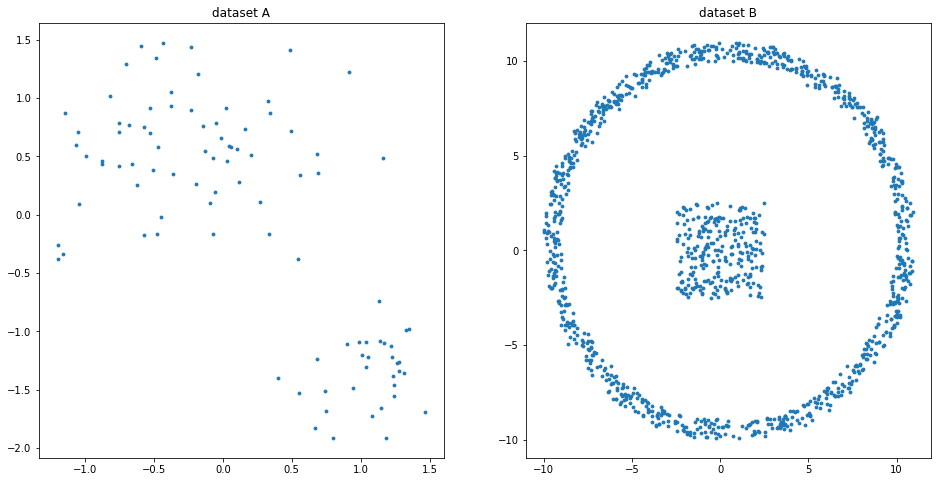

Wall time: 657 ms


In [3]:
%%time
fig, (axA, axB) = plt.subplots(1, 2)

x1, y1, x2, y2 = synthData()
X1 = np.array([x1, y1]).T
X2 = np.array([x2, y2]).T
    
# visualization
axA.scatter(x1, y1, s=8); axA.set_title('dataset A')
axB.scatter(x2, y2, s=8); axB.set_title('dataset B')

plt.savefig('output/clustering_synthetic_data.png', bbox_inches='tight')
plt.show()

## 2. k-Means
---

In [4]:
class kMeans(Distance):
    def __init__(self, K=2, iters=16, seed=1):
        super(kMeans, self).__init__()
        self._K = K
        self._iters = iters
        self._seed = seed
        self._C = None
    
    def _FNC(self, x, c, n):
        # for each point,
        # find the nearest center
        cmp = np.ndarray(n, dtype=int)
        for i, p in enumerate(x):
            d = self.distance(p, self._C)
            cmp[i] = np.argmin(d)
        return cmp
    
    def pred(self, X):
        # prediction
        n, dim = X.shape
        np.random.seed(self._seed)
        sel = np.random.randint(0, n, self._K)
        self._C = X[sel]
        cmp = self._FNC(X, self._C, n)
        for _ in range(self._iters):
            # adjust position of centroids
            # to the mean value
            for i in range(sel.size):
                P = X[cmp == i]
                self._C[i] = np.mean(P, axis=0)
            cmp = self._FNC(X, self._C, n)
        return cmp, self._C

### 2.1. Elbow method
---

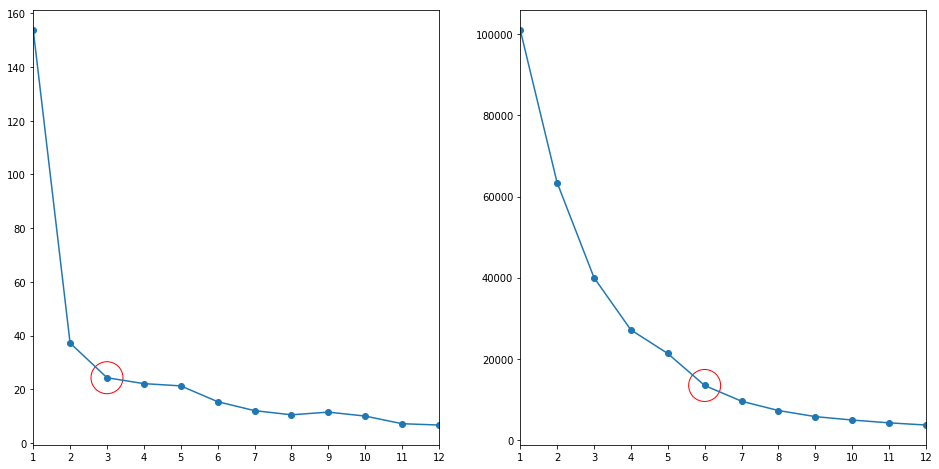

In [5]:
# elbow method
Cs = 12
V1 = np.zeros(Cs)
V2 = np.zeros(Cs)
D = Distance()
for k in range(Cs):
    kmeans = kMeans(K=k + 1, iters=48, seed=6)
    fnc1, C1 = kmeans.pred(X1)
    fnc2, C2 = kmeans.pred(X2)
    for i, [c1, c2] in enumerate(zip(C1, C2)):
        d1 = D.distance(c1, X1[fnc1 == i])**2
        d2 = D.distance(c2, X2[fnc2 == i])**2
        V1[k] += np.sum(d1)
        V2[k] += np.sum(d2)

fig, (axA, axB) = plt.subplots(1, 2)

axA.plot(range(1, Cs + 1), V1, marker='o')
axA.scatter(3, V1[2], s=1024, edgecolor='red', facecolor='none')
axA.set_xticks(range(Cs + 1))
axA.set_xlim([1, Cs])

axB.plot(range(1, Cs + 1), V2, marker='o')
axB.scatter(6, V2[5], s=1024, edgecolor='red', facecolor='none')
axB.set_xticks(range(Cs + 1))
axB.set_xlim([1, Cs])

plt.savefig('output/clustering_k-means_elbowMethod.png', bbox_inches='tight')
plt.show()

### 2.2. Visualization
---

In [6]:
%%time
fig, (axA, axB) = plt.subplots(1, 2)

iters = 21
def animation(frame):
    axA.cla() ; axB.cla()
    
    iters = frame; seed = 6
    
    K1 = 3
    kmeans1 = kMeans(K1, iters, seed)
    fnc1, C1 = kmeans1.pred(X1)
    
    K2 = 6
    kmeans2 = kMeans(K2, iters, seed)
    fnc2, C2 = kmeans2.pred(X2)
    
    axA.scatter(*X1.T, c=fnc1, s=8)
    axB.scatter(*X2.T, c=fnc2, s=8)
    axA.scatter(*C1.T, marker='*', s=256,
                c=range(K1), edgecolors='black')
    axB.scatter(*C2.T, marker='*', s=256,
                c=range(K2), edgecolors='black')
    axA.set_title('k = {0} ; i = {1:02d}'.format(K1, frame))
    axB.set_title('k = {0} ; i = {1:02d}'.format(K2, frame))

    return fig.canvas.draw()

anim = manim.FuncAnimation(fig, animation, frames=iters, interval=500)
    
anim.save('output/clustering_k-means.gif', writer="imagemagick", extra_args="convert")
plt.close()

# Solve repetition problem
! magick convert output/clustering_k-means.gif -loop 0 output/clustering_k-means.gif
! echo GIF exported and reconverted. Disregard the any message above.

GIF exported and reconverted. Disregard the any message above.
Wall time: 20.2 s


## 3. DBSCAN
---

In [7]:
class DBSCAN(Distance):
    def __init__(self, epsilon=1, minPts=4):
        super(DBSCAN, self).__init__()
        self._epsilon = epsilon
        self._minPts = minPts

    def pred(self, X):
        n = X.shape[0]
        C = 0
        label = np.zeros(n, int)
        for i, p in enumerate(X):
            if label[i]:
                continue
            d = self.distance(p, X)
            conj = d <= self._epsilon
            if np.sum(conj) - 1 < self._minPts:
                label[i] = -1
                continue
            C += 1
            argwhere = np.argwhere(conj)
            argwhere = list(np.ravel(argwhere))
            for q in argwhere:
                if label[q] == -1:
                    label[q] = C
                if label[q] != 0:
                    continue
                label[q] = C
                d = self.distance(X[q], np.delete(X, q, axis=0))
                conj2 = d <= self._epsilon
                if np.sum(conj2) >= self._minPts:
                    argwhere2 = np.ravel(np.argwhere(conj2))
                    argwhere += [a for a in argwhere2 if a not in argwhere]
        return label

### 3.1. Visualization
---

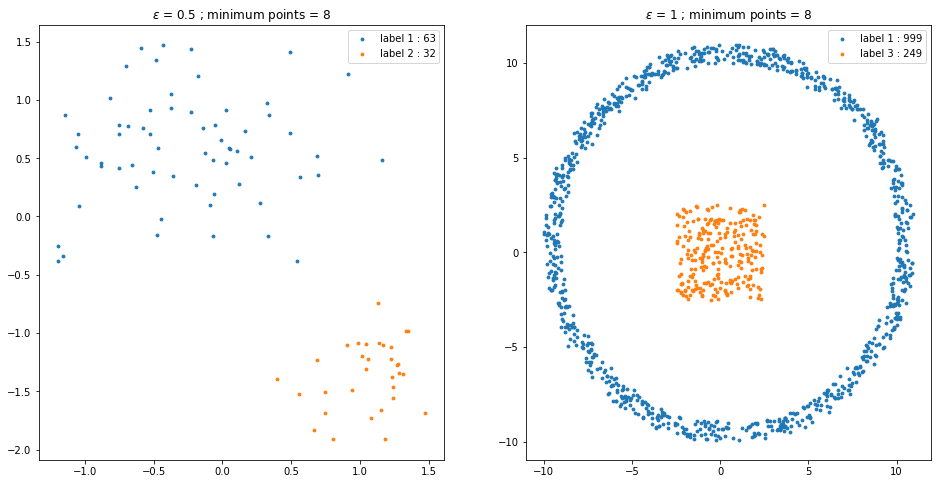

Wall time: 1.52 s


In [8]:
%%time
fig, (axA, axB) = plt.subplots(1, 2)

epsilon1 = 0.5; minPts1 = 8
dbscan1 = DBSCAN(epsilon1, minPts1)
E1 = dbscan1.pred(X1)
for e in np.unique(E1):
    p = (E1 == e).sum()
    if p > 1:
        label = 'label {0} : {1}'.format(e, p)
        axA.scatter(*X1[E1 == e].T, s=8, label=label)
axA.legend()
axA.set_title(r'$\epsilon$ = {0} ; minimum points = {1}'.format(epsilon1, minPts1))

epsilon2 = 1; minPts2 = 8
dbscan2 = DBSCAN(epsilon2, minPts2)
E2 = dbscan2.pred(X2)
for e in np.unique(E2):
    p = (E2 == e).sum()
    if p > 1:
        label = 'label {0} : {1}'.format(e, p)
        axB.scatter(*X2[E2 == e].T, s=8, label=label)
axB.legend()
axB.set_title(r'$\epsilon$ = {0} ; minimum points = {1}'.format(epsilon2, minPts2))

plt.savefig('output/clustering_dbscan.png', bbox_inches='tight')
plt.show()